In [1]:
import warnings

warnings.filterwarnings('ignore')

import csv
import torch
import shutil
import random
from tqdm import tqdm
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from transformers import BeitForImageClassification, BeitConfig

## Rearrange Dataset to use ImageFolder

In [2]:
# make sure you have following floder
# dataset
#   |-0.0
#   |-0.3333333333333333
#   |-0.6666666666666666
#   |-1.0
# dataset_test, dataset_mono and dataset_poly should be similar

import csv
import shutil

filePath = []
fileLables = []
ty = []

with open("./elpv_dataset/labels.csv", newline='') as csvfile:
    csvreader = list(csv.reader(csvfile, delimiter='\t'))
    random.shuffle(csvreader)
    for row in csvreader:
        ll = row[0].split(" ")
        filePath.append("./elpv_dataset/"+ll[0])
        fileLables.append(ll[2])
        ty.append(ll[-1])

num_of_train = 1968



for index, i in enumerate(fileLables):
    shutil.copy(filePath[index],"./dataset_train/"+str(i)+"/"+filePath[index].split("/")[-1])

for index, i in enumerate(fileLables[num_of_train:]):
    shutil.copy(filePath[index],"./dataset_test/"+str(i)+"/"+filePath[index].split("/")[-1])
    if ty[index] == "mono":
        shutil.copy(filePath[index],"./dataset_mono/"+str(i)+"/"+filePath[index].split("/")[-1])
    if ty[index] == "poly":
        shutil.copy(filePath[index],"./dataset_poly/"+str(i)+"/"+filePath[index].split("/")[-1])

## Loading Data

In [2]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = ImageFolder(root='./dataset_train', transform=transform)
val_dataset = ImageFolder(root='./dataset_test', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)

## load pretrained model

In [3]:
config = BeitConfig.from_pretrained('microsoft/beit-base-patch16-224')
model = BeitForImageClassification.from_pretrained('microsoft/beit-base-patch16-224', config=config)

model.classifier = torch.nn.Linear(model.config.hidden_size, len(train_dataset.classes))

## training

In [4]:
device = torch.device("cuda")
epoch_num = 10
lr=1e-4

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.CrossEntropyLoss().to(device)

model.to(device)

# training
for epoch in range(epoch_num):
    
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs.logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        total_correct = 0
        total_num = 0
        
        for x, label in val_loader:
            x, label = x.to(device), label.to(device)
            logits = model(x).logits
            pred = logits.argmax(dim=1)
            total_correct += torch.eq(pred,label).float().sum()
            total_num += x.size(0)
            
        acc = total_correct / total_num
        tqdm.write("epoch:{}, acc :{}".format(epoch,acc))

epoch:0, acc :0.5182926654815674
epoch:1, acc :0.49542680382728577
epoch:2, acc :0.5518292188644409
epoch:3, acc :0.48475608229637146
epoch:4, acc :0.5076219439506531
epoch:5, acc :0.49390241503715515
epoch:6, acc :0.48475608229637146
epoch:7, acc :0.4893292486667633
epoch:8, acc :0.4771341383457184
epoch:9, acc :0.5030487775802612


## Testing

              precision    recall  f1-score   support

           0       0.58      0.80      0.67       379
           1       0.10      0.04      0.06        72
           2       0.00      0.00      0.00        30
           3       0.25      0.14      0.18       175

    accuracy                           0.50       656
   macro avg       0.23      0.25      0.23       656
weighted avg       0.41      0.50      0.44       656



Text(0.5, 0.98, 'Confusion Matrix')

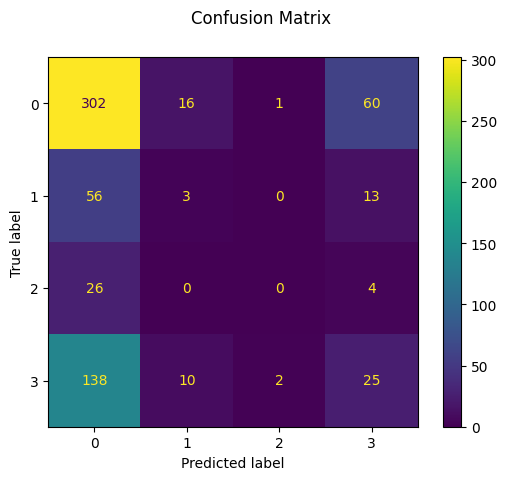

In [5]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

with torch.no_grad():
    preds = []
    truth = []
    for images, multi_labels in val_loader:
        images = images.to(device)
        multi_labels = multi_labels.to(device)
        multi_outputs = model(images).logits
        multi_preds = torch.argmax(multi_outputs, dim=-1)
        preds += multi_preds.reshape(-1).tolist()
        truth += multi_labels.reshape(-1).tolist()
        

# all
print(classification_report(truth, preds))
disp = ConfusionMatrixDisplay.from_predictions(truth, preds)
disp.figure_.suptitle("Confusion Matrix")

              precision    recall  f1-score   support

           0       0.61      0.73      0.66       161
           1       0.00      0.00      0.00        22
           2       0.00      0.00      0.00        11
           3       0.16      0.14      0.15        63

    accuracy                           0.49       257
   macro avg       0.19      0.22      0.20       257
weighted avg       0.42      0.49      0.45       257



Text(0.5, 0.98, 'Confusion Matrix Mono')

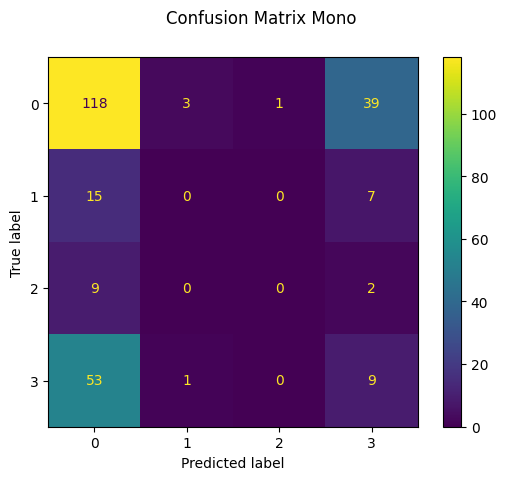

In [6]:
mono_dataset = ImageFolder(root='./dataset_mono/', transform=transform)
mono_loader = DataLoader(mono_dataset, batch_size=32, shuffle=True)

with torch.no_grad():
    preds = []
    truth = []
    for images, multi_labels in mono_loader:
        images = images.to(device)
        multi_labels = multi_labels.to(device)
        multi_outputs = model(images).logits
        multi_preds = torch.argmax(multi_outputs, dim=-1)
        preds += multi_preds.reshape(-1).tolist()
        truth += multi_labels.reshape(-1).tolist()

print(classification_report(truth, preds))
disp = ConfusionMatrixDisplay.from_predictions(truth, preds)
disp.figure_.suptitle("Confusion Matrix Mono")

              precision    recall  f1-score   support

           0       0.56      0.84      0.68       218
           1       0.12      0.06      0.08        50
           2       0.00      0.00      0.00        19
           3       0.36      0.14      0.20       112

    accuracy                           0.51       399
   macro avg       0.26      0.26      0.24       399
weighted avg       0.42      0.51      0.44       399



Text(0.5, 0.98, 'Confusion Matrix Poly')

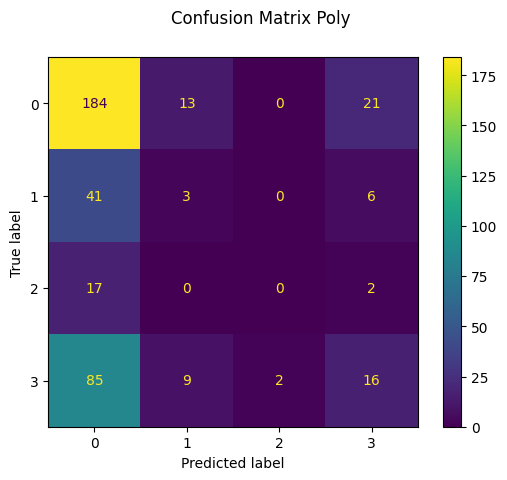

In [7]:
poly_dataset = ImageFolder(root='./dataset_poly', transform=transform)
poly_loader = DataLoader(poly_dataset, batch_size=32, shuffle=True)

with torch.no_grad():
    preds = []
    truth = []
    for images, multi_labels in poly_loader:
        images = images.to(device)
        multi_labels = multi_labels.to(device)
        multi_outputs = model(images).logits
        multi_preds = torch.argmax(multi_outputs, dim=-1)
        preds += multi_preds.reshape(-1).tolist()
        truth += multi_labels.reshape(-1).tolist()

print(classification_report(truth, preds))
disp = ConfusionMatrixDisplay.from_predictions(truth, preds)
disp.figure_.suptitle("Confusion Matrix Poly")